In [127]:
import numpy as np
import pandas as pd
import requests
import plotly.express as px

import io

from bs4 import BeautifulSoup

import re

import time 

In [128]:
year = 2018
url = f"https://www.basketball-reference.com/leagues/NBA_{year}_games.html"

# doing the web scraping
url = url
page = requests.get(url, headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"
})
soup = BeautifulSoup(page.content)
results = soup.find_all("a", href=re.compile(f"/leagues/NBA_{year}_games-"))

In [129]:
urls = []
for result in results:
    urls.append(result["href"])
urls

['/leagues/NBA_2018_games-october.html',
 '/leagues/NBA_2018_games-november.html',
 '/leagues/NBA_2018_games-december.html',
 '/leagues/NBA_2018_games-january.html',
 '/leagues/NBA_2018_games-february.html',
 '/leagues/NBA_2018_games-march.html',
 '/leagues/NBA_2018_games-april.html',
 '/leagues/NBA_2018_games-may.html',
 '/leagues/NBA_2018_games-june.html']

In [130]:
tables = []

for month in urls:
    time.sleep(5)    # Pause 5 seconds

    url = f"https://www.basketball-reference.com/{month}"

    # doing the web scraping
    url = url
    page = requests.get(url, headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"
    })
    soup = BeautifulSoup(page.content)
    results = soup.find_all("table")
    
    # converting to pandas
    df_list = pd.read_html(io.StringIO(str(results)))
    regSeason = df_list[0]  # extract the first table

    tables.append(regSeason)

regSeason = pd.concat(tables)

In [131]:
regSeason

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Arena,Notes
0,"Tue, Oct 17, 2017",8:01p,Boston Celtics,99,Cleveland Cavaliers,102,Box Score,NaN,20562,Quicken Loans Arena,NaN
1,"Tue, Oct 17, 2017",10:30p,Houston Rockets,122,Golden State Warriors,121,Box Score,NaN,19596,Oracle Arena,NaN
2,"Wed, Oct 18, 2017",7:00p,Charlotte Hornets,90,Detroit Pistons,102,Box Score,NaN,20491,Little Caesars Arena,NaN
3,"Wed, Oct 18, 2017",7:00p,Brooklyn Nets,131,Indiana Pacers,140,Box Score,NaN,15008,Bankers Life Fieldhouse,NaN
4,"Wed, Oct 18, 2017",7:00p,Miami Heat,109,Orlando Magic,116,Box Score,NaN,18846,Amway Center,NaN
...,...,...,...,...,...,...,...,...,...,...,...
29,"Mon, May 28, 2018",9:00p,Golden State Warriors,101,Houston Rockets,92,Box Score,NaN,18055,Toyota Center,NaN
30,"Thu, May 31, 2018",9:00p,Cleveland Cavaliers,114,Golden State Warriors,124,Box Score,OT,19596,Oracle Arena,NaN
0,"Sun, Jun 3, 2018",8:00p,Cleveland Cavaliers,103,Golden State Warriors,122,Box Score,NaN,19596,Oracle Arena,NaN
1,"Wed, Jun 6, 2018",9:00p,Golden State Warriors,110,Cleveland Cavaliers,102,Box Score,NaN,20562,Quicken Loans Arena,NaN


In [132]:
regSeason[regSeason["Attend."] != "Playoffs"]["Attend."].astype(int)

0     20562
1     19596
2     20491
3     15008
4     18846
      ...  
29    18055
30    19596
0     19596
1     20562
2     20562
Name: Attend., Length: 1312, dtype: int64

In [133]:
regSeason.reset_index(inplace=True)
playoffsIDX = regSeason[regSeason["PTS"] == "Playoffs"].index[0]

In [134]:
regSeason = regSeason.iloc[:playoffsIDX, :] 

In [135]:
def getHomeAwayResultsBasketball(year):

    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_games.html"

    # doing the web scraping
    url = url
    page = requests.get(url, headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"
    })
    soup = BeautifulSoup(page.content)
    results = soup.find_all("a", href=re.compile(f"/leagues/NBA_{year}_games-"))

    urls = []
    for result in results:
        urls.append(result["href"])

    tables = []

    for monthURL in urls:
        # formatted string
        url = f"https://www.basketball-reference.com/{monthURL}"
        time.sleep(5)    # Pause 5 seconds

        # doing the web scraping
        url = url
        page = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"
        })
        soup = BeautifulSoup(page.content)
        results = soup.find_all("table")
        
        # converting to pandas
        df_list = pd.read_html(io.StringIO(str(results)))
        regSeason = df_list[0]  # extract the first table

        tables.append(regSeason)

    regSeason = pd.concat(tables)
    regSeason.reset_index(inplace=True)

    # Find the index of the playoffs text and remove
    # only needed before 2018-2019 season

    if year <= 2018:
        regSeason = regSeason[regSeason["PTS"] != "Playoffs"]
    
    regSeason["PTS"] = pd.to_numeric(regSeason["PTS"])
    regSeason["PTS.1"] = pd.to_numeric(regSeason["PTS.1"])
    regSeason["Attend."] = pd.to_numeric(regSeason["Attend."])

    
    # new column creation
    regSeason["HomeWin"] = regSeason["PTS.1"] > regSeason["PTS"]
    regSeason["AwayWin"] = ~regSeason["HomeWin"]

    regSeason["PTS"] = pd.to_numeric(regSeason["PTS"])
    regSeason["PTS.1"] = pd.to_numeric(regSeason["PTS.1"])
    
    # aggregation
    homeWinStats = regSeason.groupby(["Home/Neutral"])["HomeWin"].agg(['count', 'sum', 'mean'])
    homeGoalStats = regSeason.groupby(["Home/Neutral"])["PTS.1"].agg(['sum', 'mean'])
    homeAttendanceStats = regSeason.groupby(["Home/Neutral"])["Attend."].agg(['sum', 'mean'])
    awayWinStats = regSeason.groupby(["Visitor/Neutral"])["AwayWin"].agg(['count', 'sum', 'mean'])
    awayGoalStats = regSeason.groupby(["Visitor/Neutral"])["PTS"].agg(['sum', 'mean'])
    
    # column renaming
    homeWinStats.columns = ["HomeCount", "HomeWins", "HomeWinPct"]
    homeGoalStats.columns = ["HomePoints", "AverageHomePoints"]
    homeAttendanceStats.columns = ["TotalAttendance", "AverageAttendance"]
    awayWinStats.columns = ["AwayCount", "AwayWins", "AwayWinPct"]
    awayGoalStats.columns = ["AwayPoints", "AverageAwayPoints"]
    
    # join
    mergedDF = homeWinStats.join(homeGoalStats).join(homeAttendanceStats).join(awayWinStats).join(awayGoalStats)
    mergedDF.index.name = "Team"
    mergedDF = mergedDF.round(decimals=3)
    
    # home advantage columns
    mergedDF["HomeWinAdvantage"] = mergedDF["HomeWins"] - mergedDF["AwayWins"]
    mergedDF["HomePointsAdvantage"] = mergedDF["HomePoints"] - mergedDF["AwayPoints"]
    return mergedDF

## We compared all 30 teams in the league and visualized their homefield advantage. 

In [136]:
nba2023 = getHomeAwayResultsBasketball(2023)

nba2023.head()

,HomeCount,HomeWins,HomeWinPct,HomePoints,AverageHomePoints,TotalAttendance,AverageAttendance,AwayCount,AwayWins,AwayWinPct,AwayPoints,AverageAwayPoints,HomeWinAdvantage,HomePointsAdvantage
Team,,,,,,,,,,,,,,
Atlanta Hawks,44,25,0.568,5276,119.909,776643.0,17650.977,45,19,0.422,5246,116.578,6,30
Boston Celtics,52,37,0.712,6155,118.365,976956.0,19156.000,50,31,0.620,5755,115.100,6,400
Brooklyn Nets,43,23,0.535,4819,112.070,760386.0,17683.395,43,22,0.512,4846,112.698,1,-27
Charlotte Hornets,41,13,0.317,4479,109.244,702052.0,17123.220,41,14,0.341,4619,112.659,-1,-140
Chicago Bulls,41,22,0.537,4676,114.049,841632.0,20527.610,43,19,0.442,4800,111.628,3,-124


In [137]:
nba2023.HomeWinPct[7]

/var/folders/1s/6d2kk5ms6xb3fwsbt9n4bp_m0000gn/T/ipykernel_42265/3706515117.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



0.846

In [138]:
fig = px.scatter(
    nba2023,
    x="HomeCount",
    y="HomeWins",
    color=nba2023.index,
    size=nba2023["HomeWinPct"] 
)

fig.show()

In [139]:
fig = px.scatter(
    nba2023,
    x="AwayCount",
    y="AwayWins",
    color=nba2023.index,
    size=nba2023["AwayWinPct"] 
)

fig.show()

In [140]:
fig = px.scatter(
    nba2023,
    x="HomeWins",
    y="AwayWins",
    color=nba2023.index,
    size=nba2023["AverageHomePoints"] 
)

fig.show()

## These next chunks were aimed at cleaning datsets for different teams in order to prep it to make comparison graphs. 

In [141]:
## Your code here ##

denver_data = pd.read_csv("data/Nugget.csv",index_col="Player")

In [142]:
denver_data.head

<bound method NDFrame.head of                           Rk  Age   G  GS    MP   FG   FGA    FG%   3P  3PA  \
Player                                                                        
Nikola Jokić               1   27  69  69  33.7  9.4  14.8  0.632  0.8  2.2   
Jamal Murray               2   25  65  65  32.8  7.3  16.0  0.454  2.6  6.6   
Kentavious Caldwell-Pope   3   29  76  76  31.3  3.8   8.3  0.462  1.8  4.2   
Aaron Gordon               4   27  68  68  30.2  6.3  11.2  0.564  0.9  2.5   
Michael Porter Jr.         5   24  62  62  29.0  6.4  13.2  0.487  3.0  7.3   
Bruce Brown                6   26  80  31  28.5  4.5   9.3  0.483  1.1  3.2   
Reggie Jackson             7   32  16   2  19.9  3.1   8.0  0.383  1.2  4.3   
Jeff Green                 8   36  56   4  19.5  2.9   5.9  0.488  0.5  1.9   
Bones Hyland               9   22  42   1  19.5  4.1  10.3  0.399  2.2  5.7   
Christian Braun           10   21  76   6  15.5  1.9   3.8  0.495  0.4  1.3   
DeAndre Jordan        

In [143]:
denver_data.columns

Index(['Rk', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [144]:
numeric_columns = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

In [145]:
denver_data[numeric_columns]

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Nikola Jokić,27,69,69,33.7,9.4,14.8,0.632,0.8,2.2,0.383,...,0.822,2.4,9.4,11.8,9.8,1.3,0.7,3.6,2.5,24.5
Jamal Murray,25,65,65,32.8,7.3,16.0,0.454,2.6,6.6,0.398,...,0.833,0.7,3.2,4.0,6.2,1.0,0.2,2.2,1.6,20.0
Kentavious Caldwell-Pope,29,76,76,31.3,3.8,8.3,0.462,1.8,4.2,0.423,...,0.824,0.5,2.3,2.7,2.4,1.5,0.5,1.1,1.9,10.8
Aaron Gordon,27,68,68,30.2,6.3,11.2,0.564,0.9,2.5,0.347,...,0.608,2.4,4.1,6.6,3.0,0.8,0.8,1.4,1.9,16.3
Michael Porter Jr.,24,62,62,29.0,6.4,13.2,0.487,3.0,7.3,0.414,...,0.800,1.0,4.5,5.5,1.0,0.6,0.5,1.1,1.9,17.4
Bruce Brown,26,80,31,28.5,4.5,9.3,0.483,1.1,3.2,0.358,...,0.758,0.8,3.3,4.1,3.4,1.1,0.6,1.5,2.4,11.5
Reggie Jackson,32,16,2,19.9,3.1,8.0,0.383,1.2,4.3,0.279,...,0.833,0.2,1.6,1.8,3.1,0.6,0.1,1.2,1.4,7.9
Jeff Green,36,56,4,19.5,2.9,5.9,0.488,0.5,1.9,0.288,...,0.744,0.7,1.9,2.6,1.2,0.3,0.3,0.8,1.8,7.8
Bones Hyland,22,42,1,19.5,4.1,10.3,0.399,2.2,5.7,0.378,...,0.866,0.2,1.8,2.0,3.0,0.7,0.3,1.6,1.6,12.1


In [146]:
clean_data = denver_data[numeric_columns].dropna()

In [147]:
denver_rotation= clean_data[0:8]

denver_rotation

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Nikola Jokić,27,69,69,33.7,9.4,14.8,0.632,0.8,2.2,0.383,...,0.822,2.4,9.4,11.8,9.8,1.3,0.7,3.6,2.5,24.5
Jamal Murray,25,65,65,32.8,7.3,16.0,0.454,2.6,6.6,0.398,...,0.833,0.7,3.2,4.0,6.2,1.0,0.2,2.2,1.6,20.0
Kentavious Caldwell-Pope,29,76,76,31.3,3.8,8.3,0.462,1.8,4.2,0.423,...,0.824,0.5,2.3,2.7,2.4,1.5,0.5,1.1,1.9,10.8
Aaron Gordon,27,68,68,30.2,6.3,11.2,0.564,0.9,2.5,0.347,...,0.608,2.4,4.1,6.6,3.0,0.8,0.8,1.4,1.9,16.3
Michael Porter Jr.,24,62,62,29.0,6.4,13.2,0.487,3.0,7.3,0.414,...,0.800,1.0,4.5,5.5,1.0,0.6,0.5,1.1,1.9,17.4
Bruce Brown,26,80,31,28.5,4.5,9.3,0.483,1.1,3.2,0.358,...,0.758,0.8,3.3,4.1,3.4,1.1,0.6,1.5,2.4,11.5
Reggie Jackson,32,16,2,19.9,3.1,8.0,0.383,1.2,4.3,0.279,...,0.833,0.2,1.6,1.8,3.1,0.6,0.1,1.2,1.4,7.9
Jeff Green,36,56,4,19.5,2.9,5.9,0.488,0.5,1.9,0.288,...,0.744,0.7,1.9,2.6,1.2,0.3,0.3,0.8,1.8,7.8


In [148]:
denver_rotation.mean()

Age     28.250000
G       61.500000
GS      47.125000
MP      28.112500
FG       5.462500
FGA     10.837500
FG%      0.494125
3P       1.487500
3PA      4.025000
3P%      0.361250
2P       3.937500
2PA      6.825000
2P%      0.563250
eFG%     0.563375
FT       2.137500
FTA      2.775000
FT%      0.777750
ORB      1.087500
DRB      3.787500
TRB      4.887500
AST      3.762500
STL      0.900000
BLK      0.462500
TOV      1.612500
PF       1.925000
PTS     14.525000
dtype: float64

In [149]:
miami_data = pd.read_csv("data/Heat.csv",index_col="Player")

In [150]:
clean_miami = miami_data[numeric_columns].dropna()

In [151]:
miami_rotation = clean_miami[0:8]

miami_rotation

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Tyler Herro,23,67,67,34.9,7.3,16.6,0.439,3.0,8.0,0.378,...,0.934,0.4,5.0,5.4,4.2,0.8,0.2,2.4,1.5,20.1
Bam Adebayo,25,75,75,34.6,8.0,14.9,0.540,0.0,0.2,0.083,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
Jimmy Butler,33,64,64,33.4,7.5,13.9,0.539,0.6,1.6,0.350,...,0.850,2.2,3.7,5.9,5.3,1.8,0.3,1.6,1.3,22.9
Kyle Lowry,36,55,44,31.2,3.6,8.8,0.404,1.9,5.6,0.345,...,0.859,0.8,3.3,4.1,5.1,1.0,0.4,1.9,2.6,11.2
Caleb Martin,27,71,49,29.3,3.6,7.7,0.464,1.2,3.3,0.356,...,0.805,1.2,3.6,4.8,1.6,1.0,0.4,1.1,2.0,9.6
Max Strus,26,80,33,28.4,4.1,9.9,0.410,2.5,7.0,0.350,...,0.876,0.6,2.6,3.2,2.1,0.5,0.2,0.9,2.1,11.5
Victor Oladipo,30,42,2,26.3,3.8,9.6,0.397,1.7,5.0,0.330,...,0.747,0.4,2.7,3.0,3.5,1.4,0.3,2.1,2.4,10.7
Gabe Vincent,26,68,34,25.9,3.4,8.3,0.402,1.7,5.1,0.334,...,0.872,0.4,1.7,2.1,2.5,0.9,0.1,1.4,2.3,9.4


In [152]:
miami_rotation.mean()

Age     28.250000
G       65.250000
GS      46.000000
MP      30.500000
FG       5.162500
FGA     11.212500
FG%      0.449375
3P       1.575000
3PA      4.475000
3P%      0.315750
2P       3.550000
2PA      6.700000
2P%      0.525250
eFG%     0.526250
FT       2.625000
FTA      3.125000
FT%      0.843625
ORB      1.062500
DRB      3.662500
TRB      4.712500
AST      3.437500
STL      1.075000
BLK      0.337500
TOV      1.737500
PF       2.125000
PTS     14.475000
dtype: float64

In [153]:
lakers_data = pd.read_csv("data/Lakers.csv",index_col="Player")

In [154]:
clean_lakers = lakers_data[numeric_columns].dropna()

lakers_rotation = clean_lakers[0:8]

In [155]:
nuggets_3P = denver_rotation['3P%'].mean()

nuggets_3P

0.36125

In [156]:
lakers_3P = lakers_rotation['3P%'].mean()

lakers_3P

0.343

In [157]:
heat_3P = miami_rotation['3P%'].mean()

heat_3P

0.31575

In [94]:
suns_data = pd.read_csv("data/Suns.csv",index_col="Player")

In [96]:
clean_suns = suns_data[numeric_columns].dropna()

suns_rotation = clean_suns[0:8]

In [97]:
suns_3P = suns_rotation['3P%'].mean()

suns_3P

0.404625

In [98]:
wolves_data = pd.read_csv("data/Wolves.csv",index_col="Player")

In [99]:
clean_wolves = wolves_data[numeric_columns].dropna()

wolves_rotation = clean_wolves[0:8]

In [101]:
wolves_3P = wolves_rotation['3P%'].mean()

wolves_3P

0.341875

## The next few graphs will look at various variables between the Nuggets and the 4 teams they played in the playoffs last year. 

In [66]:
import matplotlib.pyplot as plt

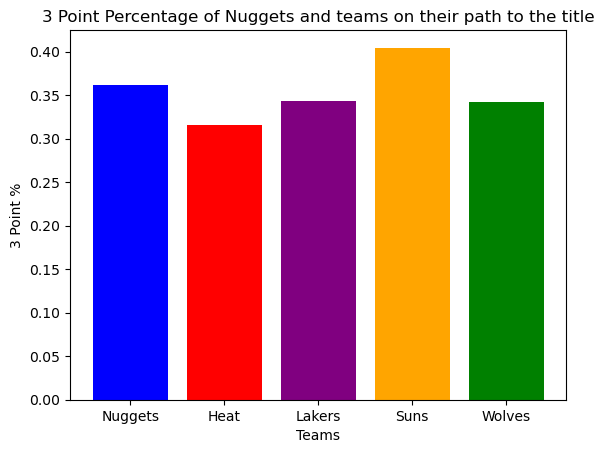

In [103]:
Teams = ['Nuggets', 'Heat', 'Lakers',  'Suns', 'Wolves']
three_percentages = [0.36125, 0.31575, 0.343, 0.404625, 0.341875]

plt.bar(Teams, three_percentages, color= ['blue','red','purple','orange', 'green'])

plt.xlabel('Teams')
plt.ylabel('3 Point %')
plt.title('3 Point Percentage of Nuggets and teams on their path to the title')

plt.show()

In [104]:
nuggets_TOV = denver_rotation['TOV'].mean()

nuggets_TOV

1.6125

In [105]:
heat_TOV = miami_rotation['TOV'].mean()

heat_TOV

1.7375

In [106]:
lakers_TOV = lakers_rotation['TOV'].mean()

lakers_TOV

1.9875

In [108]:
suns_TOV = suns_rotation['TOV'].mean()

suns_TOV

1.6125

In [109]:
wolves_TOV = wolves_rotation['TOV'].mean()

wolves_TOV

2.0124999999999997

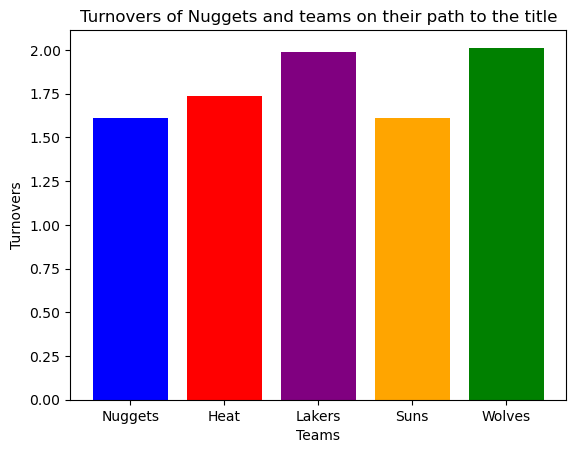

In [110]:
Teams = ['Nuggets', 'Heat', 'Lakers',  'Suns', 'Wolves']
Turnovers = [1.6125, 1.7375, 1.9875, 1.6125, 2.0124999999999997]

plt.bar(Teams, Turnovers, color= ['blue','red','purple','orange', 'green'])

plt.xlabel('Teams')
plt.ylabel('Turnovers')
plt.title('Turnovers of Nuggets and teams on their path to the title')

plt.show()

In [114]:
nuggets_drb = denver_rotation['DRB'].mean()

nuggets_drb

3.7875

In [115]:
heat_drb = miami_rotation['DRB'].mean()

heat_drb

3.6625

In [116]:
lakers_drb = lakers_rotation['DRB'].mean()

lakers_drb

4.275

In [117]:
suns_drb = suns_rotation['DRB'].mean()

suns_drb

4.1625

In [118]:
wolves_drb = wolves_rotation['DRB'].mean()

wolves_drb

4.2875

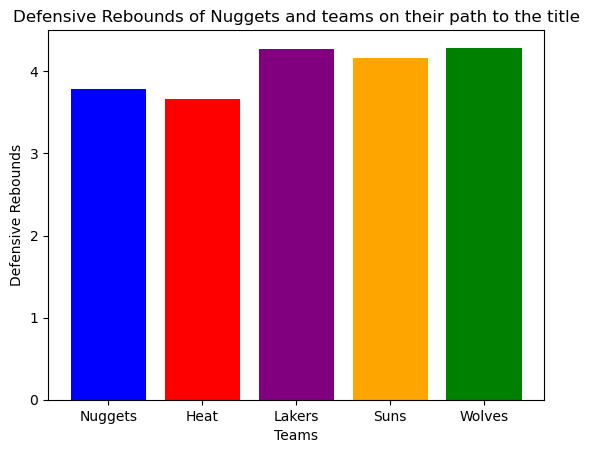

In [119]:
Teams = ['Nuggets', 'Heat', 'Lakers',  'Suns', 'Wolves']
defensive_rebounds = [3.7875, 3.6625, 4.275, 4.1625, 4.2875]

plt.bar(Teams, defensive_rebounds, color= ['blue','red','purple','orange', 'green'])

plt.xlabel('Teams')
plt.ylabel('Defensive Rebounds')
plt.title('Defensive Rebounds of Nuggets and teams on their path to the title')

plt.show()

In [125]:
nuggets_assists = denver_rotation['AST'].mean()

nuggets_assists

3.7624999999999997

In [124]:
heat_assists = miami_rotation['AST'].mean()

heat_assists

3.4374999999999996

In [122]:
lakers_assists = lakers_rotation['AST'].mean()

lakers_assists

4.35

In [121]:
suns_assists = suns_rotation['AST'].mean()

suns_assists

3.4375

In [120]:
wolves_assists = wolves_rotation['AST'].mean()

wolves_assists

3.75

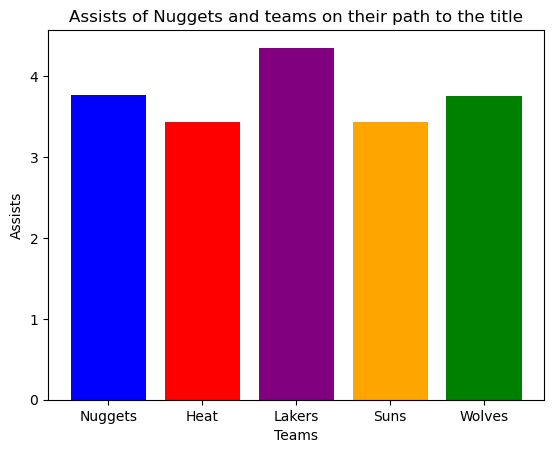

In [126]:
Teams = ['Nuggets', 'Heat', 'Lakers',  'Suns', 'Wolves']
assists = [3.7624999999999997, 3.4374999999999996, 4.35, 3.4375, 3.75]

plt.bar(Teams, assists, color= ['blue','red','purple','orange', 'green'])

plt.xlabel('Teams')
plt.ylabel('Assists')
plt.title('Assists of Nuggets and teams on their path to the title')

plt.show()

Below, we compared different players on the Nuggets' data and took a closer look at Kentavious Caldwell-Pope (KCP).

In [25]:
fig = px.scatter(
    clean_data,
    x="FG%",
    y="PTS",
    color=clean_data.index,
    size=clean_data["G"] 
)

fig.show()

In [26]:

KCP_data = pd.read_csv("data/KCP.csv",index_col="Season")

In [27]:
KCP_data.tail

<bound method NDFrame.tail of          Age   Tm   Lg Pos   G  GS    MP   FG   FGA    FG%  ...    FT%  ORB  \
Season                                                      ...               
2013-14   20  DET  NBA  SG  80  41  19.8  2.3   5.8  0.396  ...  0.770  0.5   
2014-15   21  DET  NBA  SG  82  82  31.5  4.8  11.9  0.401  ...  0.696  0.6   
2015-16   22  DET  NBA  SG  76  76  36.7  5.3  12.6  0.420  ...  0.811  0.9   
2016-17   23  DET  NBA  SG  76  75  33.3  4.9  12.2  0.399  ...  0.832  0.7   
2017-18   24  LAL  NBA  SG  74  74  33.2  4.6  10.8  0.426  ...  0.789  0.8   
2018-19   25  LAL  NBA  SG  82  23  24.8  4.0   9.2  0.430  ...  0.867  0.6   
2019-20   26  LAL  NBA  SG  69  26  25.5  3.4   7.3  0.467  ...  0.775  0.6   
2020-21   27  LAL  NBA  SG  67  67  28.4  3.3   7.6  0.431  ...  0.866  0.4   
2021-22   28  WAS  NBA  SG  77  77  30.2  4.7  10.8  0.435  ...  0.890  0.5   
2022-23   29  DEN  NBA  SG  76  76  31.3  3.8   8.3  0.462  ...  0.824  0.5   
2023-24   30  DEN  NBA

In [34]:
KCP_data.columns

Index(['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [37]:
Col= ['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

In [38]:
KCP_data[Col]

,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Season,,,,,,,,,,,,,,,,,,,,,
2013-14,20,DET,NBA,SG,80,41,19.8,2.3,5.8,0.396,...,0.770,0.5,1.5,2.0,0.7,0.9,0.2,0.4,1.8,5.9
2014-15,21,DET,NBA,SG,82,82,31.5,4.8,11.9,0.401,...,0.696,0.6,2.5,3.1,1.3,1.1,0.2,1.1,2.0,12.7
2015-16,22,DET,NBA,SG,76,76,36.7,5.3,12.6,0.420,...,0.811,0.9,2.8,3.7,1.8,1.4,0.2,1.4,2.2,14.5
2016-17,23,DET,NBA,SG,76,75,33.3,4.9,12.2,0.399,...,0.832,0.7,2.5,3.3,2.5,1.2,0.2,1.1,1.6,13.8
2017-18,24,LAL,NBA,SG,74,74,33.2,4.6,10.8,0.426,...,0.789,0.8,4.4,5.2,2.2,1.4,0.2,1.3,2.0,13.4
2018-19,25,LAL,NBA,SG,82,23,24.8,4.0,9.2,0.430,...,0.867,0.6,2.3,2.9,1.3,0.9,0.2,0.8,1.7,11.4
2019-20,26,LAL,NBA,SG,69,26,25.5,3.4,7.3,0.467,...,0.775,0.6,1.5,2.1,1.6,0.8,0.2,0.9,1.9,9.3
2020-21,27,LAL,NBA,SG,67,67,28.4,3.3,7.6,0.431,...,0.866,0.4,2.3,2.7,1.9,0.9,0.4,1.0,1.7,9.7
2021-22,28,WAS,NBA,SG,77,77,30.2,4.7,10.8,0.435,...,0.890,0.5,2.9,3.4,1.9,1.1,0.3,1.3,1.8,13.2


In [39]:
clean_data = KCP_data[Col].dropna()

In [41]:
fig = px.scatter(
    KCP_data,
    x="Age",
    y="FT%",
    color=KCP_data.index,
    size=KCP_data["GS"] 
)

fig.show()

## Below, we tried to use linear regression in a way to make sense of the various variables in the day and how they contribute to Denver's overall team. The function ran, however, we were not really sure what to make of this return value, so we abandoned this process. 

In [ ]:
#lets look just at denver stats 
nba2023_denver = nba2023.reset_index(drop=True)
denver_row = nba2023_denver.loc[7, :]

print(denver_row)

In [158]:
from sklearn.linear_model import LinearRegression

off_col= ["FG", "FGA", "FG%",'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB','AST','PTS'] 
denver_data_off=denver_data[off_col]

denver_data_off

def_col=['DRB','TRB','STL','BLK','PF']
denver_data_def=denver_data[def_col]

denver_data_def

gamestart=denver_data["GS"]


off_data=LinearRegression().fit(denver_data_off,gamestart)
print(off_data.score(denver_data_off,gamestart))

def_data=LinearRegression().fit(denver_data_def,gamestart)
print(def_data.score(denver_data_def,gamestart))

0.9123057281115289
0.8027314567655685


/Users/reubendayal/anaconda3/envs/mssa60230/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/reubendayal/anaconda3/envs/mssa60230/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/reubendayal/anaconda3/envs/mssa60230/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/reubendayal/anaconda3/envs/mssa60230/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/reubendayal/anaconda3/envs/mssa60230/